In [1]:
!pip install lightning

  Obtaining dependency information for lightning from https://files.pythonhosted.org/packages/8c/a1/b2a6c33675510bc3e1ca6d010b244ac0dd9c81fc1723a37e7491aa586041/lightning-2.1.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 931.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00ta 0:00:01


In [8]:
!mkdir /kaggle/working/log2

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import albumentations as A
import torch
import cv2
import matplotlib.pyplot as plt
import lightning as pl
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
BATCH_SIZE = 16
OUT_DIR = "/kaggle/working/log"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
from torch.utils.data import Dataset, DataLoader
from albumentations.augmentations.geometric.resize import Resize 
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.crops.transforms import CenterCrop
from torchvision import transforms


class asl_data(Dataset):
    def __init__(self, df, mode):
        #self.vl = var_list
        self.mode = mode
        self.df = df
    def __getitem__(self,idx):
        cur_row = self.df.iloc[idx]
        if self.mode == "train":
            img = cv2.imread(f"/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/{cur_row.label}/{cur_row.image_id}")
        else:
            img = cv2.imread(f"/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/{cur_row.image_id}")
        #print(type(img))
        transform = A.Compose([Resize(224,224), ToTensorV2()])
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #print(img)
        #print(transform(image=img)["image"].permute(1, 2, 0))
        #print(transform(image=img)["image"].permute(1, 2, 0).shape)
        
        return norm(transform(image=img)["image"].float()/255), CLASSES.index(cur_row.label)
        #return transform(image=img)["image"].float()/255, CLASSES.index(cur_row.label)

        
    def __len__(self):
        return len(self.df.index)


In [33]:
FileDict = {'image_id': [label+str(i+1)+".jpg" for label in CLASSES for i in range(3000)],'label': [label for label in CLASSES for _ in range(3000)]}
TestDict = {'image_id': [label+"_test.jpg" for label in CLASSES if label != "del"],'label': [label for label in CLASSES if label != "del"]}
print( FileDict['image_id'][:5],  FileDict['label'][:5])
df = pd.DataFrame(FileDict)
test_df = pd.DataFrame(TestDict)
df

['A1.jpg', 'A2.jpg', 'A3.jpg', 'A4.jpg', 'A5.jpg'] ['A', 'A', 'A', 'A', 'A']


,image_id,label
0,A1.jpg,A
1,A2.jpg,A
2,A3.jpg,A
3,A4.jpg,A
4,A5.jpg,A
...,...,...
86995,space2996.jpg,space
86996,space2997.jpg,space
86997,space2998.jpg,space
86998,space2999.jpg,space


In [34]:
test_df

,image_id,label
0,A_test.jpg,A
1,B_test.jpg,B
2,C_test.jpg,C
3,D_test.jpg,D
4,E_test.jpg,E
5,F_test.jpg,F
6,G_test.jpg,G
7,H_test.jpg,H
8,I_test.jpg,I
9,J_test.jpg,J


In [35]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.20)

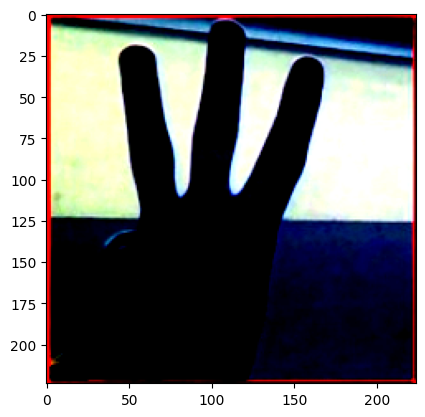

In [36]:

train_data = asl_data(train_df, "train")
val_data = asl_data(val_df, "train")
test_data = asl_data(test_df, "test")
train_loader = DataLoader(train_data, 
                          batch_size = BATCH_SIZE, 
                          num_workers=3,
                          shuffle = True)
val_loader = DataLoader(val_data, 
                          batch_size = BATCH_SIZE, 
                        num_workers=3,
                          shuffle = False)
test_loader = DataLoader(test_data, 
                          batch_size = BATCH_SIZE, 
                        num_workers=3,
                          shuffle = False)
#print(train_data[5][0].shape)
image = train_data[5][0].permute(1, 2, 0)
#image = train_data[5][0]
#print(image)
#print(image.shape)

plt.imshow(image.numpy(), vmin=0.0, vmax=1.0)


In [7]:
import torch.nn as nn

class my_resnet18(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 6:
                for param in child.parameters():
                    param.requires_grad = False
            #print(child.name)
        #print(ct)
        self.classifier = nn.Sequential(nn.Linear(1000, len(CLASSES)))
        
    def forward(self,x):
        return self.classifier(self.net(x))

In [8]:
#model


import lightning.pytorch as pl
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class my_resnet18_PL(pl.LightningModule):
    def __init__(self, resnet):
        super().__init__()
        #self.num_outs = num_classes
        self.acc_list = []
        self.E_acc = []
        self.val_lost_list = []
        self.E_val_loss = []
        self.train_lost_list = []
        self.E_train_loss = []
        self.epoch = 0
        self.resnet = resnet
        
        
    def forward(self, x):
        return self.resnet(x)
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y_t = batch
        
        y_p = self(x)
        #print("xshape", x.shape)
        #print("y_P", y_p.shape)
        
        #print("y_p", y_p)
        #print("x", x)
        loss = F.cross_entropy(y_p, y_t)
        self.train_lost_list.append(loss.item())
        return loss
    
   
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            # training_step defines the train loop.
            #print("batch", batch)
            x, y_t = batch
            y_p = self(x)
            #print("y_p", y_p)
            #print("y_t", y_t)
            loss = F.cross_entropy(y_p, y_t)
            temp = torch.zeros(BATCH_SIZE, 5)
            #for i in range(BATCH_SIZE):
            #    temp[i, y_t[i]] = 1
            #y_t = temp
            #print(y_t.shape, y_p.shape)
            #print(y_p)
            #print(torch.argmax(y_p, dim=1))
            y_p = torch.argmax(y_p, dim=1)
            acc = accuracy_score(y_t.cpu().numpy(), y_p.cpu().numpy())

            #self.log("val_loss", loss.item(),prog_bar=True)
            self.acc_list.append(acc)
            self.val_lost_list.append(loss.item())
            #return loss
    
    def on_train_epoch_end(self) -> None:
        loss = sum(self.train_lost_list) / len(self.train_lost_list)
        self.E_train_loss.append(loss)
    
    def on_validation_epoch_end(self) -> None:
       
        loss = sum(self.val_lost_list) / len(self.val_lost_list)
        acc = sum(self.acc_list) / len(self.acc_list)
        self.E_val_loss.append(loss)
        self.E_acc.append(acc)
        
        if ((self.epoch+1) % 2) == 0:
            figure_1, train_ax = plt.subplots()
            figure_2, valid_ax = plt.subplots()
            #print(model.train_lost_list)
            train_ax.plot(self.E_train_loss, color='blue')
            train_ax.set_xlabel('epochs')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(self.E_val_loss, color='red')
            valid_ax.plot(self.E_acc, color='green')
            valid_ax.set_xlabel('epochs')
            valid_ax.set_ylabel('metric')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{self.epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{self.epoch+1}.png")
            torch.save(self.resnet.state_dict(), 
                f"{OUT_DIR}/resnet_{self.epoch+1}_model.pth")
            print(f'SAVING PLOTS COMPLETE...{self.epoch+1}')
        self.epoch += 1
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.04)

In [10]:
rn = my_resnet18();
model = my_resnet18_PL(rn)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s] 


In [ ]:
trainer = pl.Trainer(max_epochs=50, default_root_dir="/kaggle/working/log2", log_every_n_steps=13, accelerator="gpu", devices="auto")
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders = val_loader)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name   | Type        | Params
---------------------------------------
0 | resnet | my_resnet18 | 11.7 M
---------------------------------------
11.6 M    Trainable params
157 K     Non-trainable params
11.7 M    Total params
46.874    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...2


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...4


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...6


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...8


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...10


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...12


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...14


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...16


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...18


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...20


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_42/3691316571.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure_1, train_ax = plt.subplots()


SAVING PLOTS COMPLETE...22


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...24


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

SAVING PLOTS COMPLETE...26


In [11]:
rn.load_state_dict(torch.load("/kaggle/working/log/resnet_24_model.pth"))
model = my_resnet18_PL(rn)

In [13]:
from sklearn.metrics import confusion_matrix
device = DEVICE
print(device)
y_gt_all = []
y_pr_all = []
model.eval()
model.to(device)
with torch.no_grad():  # declare no gradient operations
    for step, minibatch in enumerate(val_loader):
        # 1. Get a minibatch data for testing
        x, y_gt = minibatch[0], minibatch[1]
        x = x.to(device)        # of size (batchsize, 3, H, W)
        y_gt = y_gt.to(device)  # of size (batchsize, 1)
        

        # 2. Compute the forward pass
        y_pr = model(x)         # of size (batchsize, n_classes)
        y_pr = F.softmax(y_pr, dim=1)

        # 3. Get y_gt and y_pr to compute the performance metric of the test set
        y_gt = y_gt.detach().cpu().numpy()
        y_pr = y_pr.detach().cpu().numpy()
        y_gt_all = np.concatenate((y_gt_all, y_gt), axis=0) if len(y_gt_all) > 0 else y_gt
        y_pr_all = np.concatenate((y_pr_all, y_pr), axis=0) if len(y_pr_all) > 0 else y_pr


cuda


In [14]:
conf_mat = confusion_matrix(y_gt_all, np.argmax(y_pr_all, axis=1))


Text(0.5, 1.0, 'Confusion Matrix')

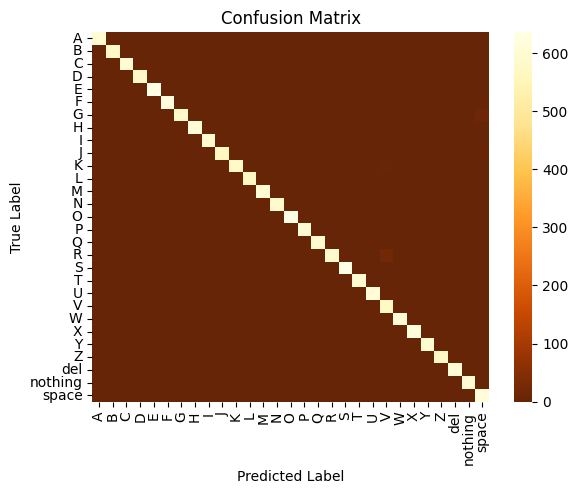

In [15]:
import seaborn as sns

tick_labels = CLASSES
sns.heatmap(conf_mat, xticklabels=tick_labels, yticklabels=tick_labels, cmap= sns.color_palette("YlOrBr_r", as_cmap=True))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#plt.savefig('conf_mat.png')

In [16]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def compute_metrics(y_pr, y_gt, label_list):
    """
    Compute performance metrics of y_pr and y_gt
    Args:
        y_pr: 2D array of size (batchsize, n_classes)
        y_gt: 1D array of size (batchsize,)
        label_list: list of labels of the classification problem
    Returns: dictionary of metrics:
    """
 
    if len(label_list) == 2:
        # Get the prob. of label-1 class
        y_pr = y_pr[:, 1]
        auc = roc_auc_score(y_true=y_gt, y_score=y_pr)

        # Get the output labels of the y_pr
        threshold = 0.5
        y_pr[y_pr >= threshold] = 1.0
        y_pr[y_pr < threshold] = 0.0
        accuracy = accuracy_score(y_true=y_gt, y_pred=y_pr)
        precision = precision_score(y_true=y_gt, y_pred=y_pr, pos_label=1, 
                                    average='binary', zero_division=1)
        recall = recall_score(y_true=y_gt, y_pred=y_pr, pos_label=1, 
                              average='binary')
        f1_score = fbeta_score(y_true=y_gt, y_pred=y_pr, beta=1, pos_label=1, 
                               average='binary')
        f2_score = fbeta_score(y_true=y_gt, y_pred=y_pr, beta=2, pos_label=1, 
                               average='binary')

    else:
        # Compute the one-hot coding of the y-gt
        try: 
            y_onehot = np.zeros(y_pr.shape)
            for k in range(len(y_gt)):
                y_onehot[k, y_gt[k]] = 1
            auc = roc_auc_score(y_true=y_onehot, y_score=y_pr)
        
        except Exception: # error when not all classes presented in y_gt
            auc = 0

        # Get the output labels of the y_pr
        y_pr = np.argmax(y_pr, axis=1)
        accuracy = accuracy_score(y_true=y_gt, y_pred=y_pr)
        precision = precision_score(y_true=y_gt, y_pred=y_pr, labels=label_list, 
                                    average='macro', zero_division=1)
        recall = recall_score(y_true=y_gt, y_pred=y_pr, pos_label=1, 
                              labels=label_list, average='macro')
        f1_score = fbeta_score(y_true=y_gt, y_pred=y_pr, beta=1, 
                               labels=label_list, average='macro')
        f2_score = fbeta_score(y_true=y_gt, y_pred=y_pr, beta=1, 
                               labels=label_list, average='macro')

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall,
            'f1_score': f1_score, 'f2_score': f2_score, 'auc': auc}

In [17]:
class_id_list = list(range(len(CLASSES)))
performance = compute_metrics(y_pr_all, y_gt_all, class_id_list)
print(f"Testing performance: ")
for k, v in performance.items():
    print(f'\t{k}: \t{v:.4f}')

Testing performance: 
	accuracy: 	0.9954
	precision: 	0.9955
	recall: 	0.9954
	f1_score: 	0.9954
	f2_score: 	0.9954
	auc: 	0.9988


In [18]:
l=[[v] for k,v in performance.items()]

df = pd.DataFrame(l)
df.index = performance.keys()

In [20]:
df

,0
accuracy,0.995402
precision,0.995492
recall,0.995378
f1_score,0.995389
f2_score,0.995389
auc,0.998769


In [37]:
from sklearn.metrics import confusion_matrix
device = DEVICE
print(device)
y_gt_all = []
y_pr_all = []
model.eval()
model.to(device)
with torch.no_grad():  # declare no gradient operations
    for step, minibatch in enumerate(test_loader):
        # 1. Get a minibatch data for testing
        x, y_gt = minibatch[0], minibatch[1]
        x = x.to(device)        # of size (batchsize, 3, H, W)
        y_gt = y_gt.to(device)  # of size (batchsize, 1)
        

        # 2. Compute the forward pass
        y_pr = model(x)         # of size (batchsize, n_classes)
        y_pr = F.softmax(y_pr, dim=1)

        # 3. Get y_gt and y_pr to compute the performance metric of the test set
        y_gt = y_gt.detach().cpu().numpy()
        y_pr = y_pr.detach().cpu().numpy()
        y_gt_all = np.concatenate((y_gt_all, y_gt), axis=0) if len(y_gt_all) > 0 else y_gt
        y_pr_all = np.concatenate((y_pr_all, y_pr), axis=0) if len(y_pr_all) > 0 else y_pr


cuda


In [38]:
class_id_list = list(range(len(CLASSES)))
performance = compute_metrics(y_pr_all, y_gt_all, class_id_list)
print(f"Testing performance *Test_set: ")
for k, v in performance.items():
    print(f'\t{k}: \t{v:.4f}')

Testing performance *Test_set: 
	accuracy: 	1.0000
	precision: 	1.0000
	recall: 	0.9655
	f1_score: 	0.9655
	f2_score: 	0.9655
	auc: 	0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [39]:
l=[[v] for k,v in performance.items()]

df = pd.DataFrame(l)
df.index = performance.keys()
df

,0
accuracy,1.000000
precision,1.000000
recall,0.965517
f1_score,0.965517
f2_score,0.965517
auc,0.000000


Text(0.5, 1.0, 'Confusion Matrix')

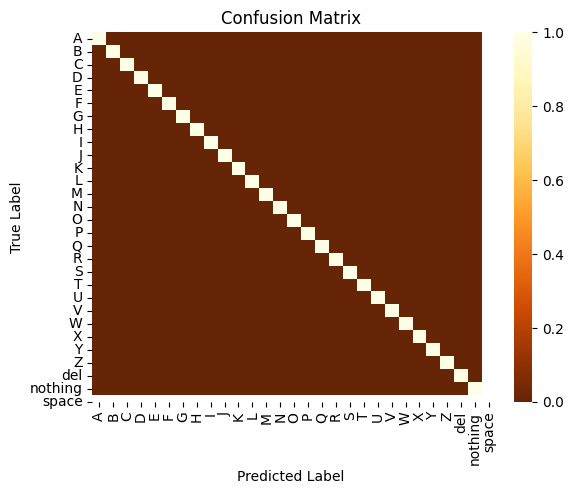

In [40]:
conf_mat = confusion_matrix(y_gt_all, np.argmax(y_pr_all, axis=1))
import seaborn as sns

tick_labels = CLASSES
sns.heatmap(conf_mat, xticklabels=tick_labels, yticklabels=tick_labels, cmap= sns.color_palette("YlOrBr_r", as_cmap=True))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#plt.savefig('conf_mat.png')


[ WARN:0@2026.950] global loadsave.cpp:248 findDecoder imread_('/kaggle/working/log/val_loss_24.png'): can't open/read file: check file path/integrity


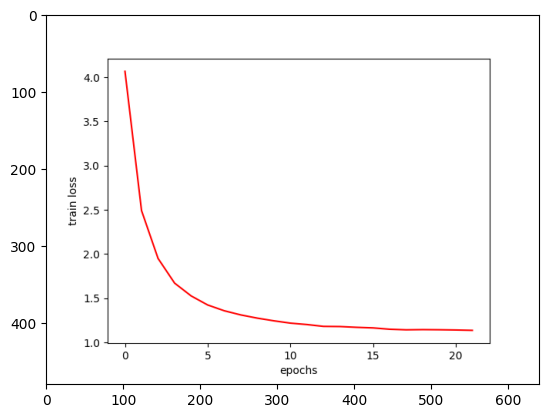

In [41]:
train_img = cv2.imread(f"{OUT_DIR}/train_loss_24.png")
plt.imshow(train_img)

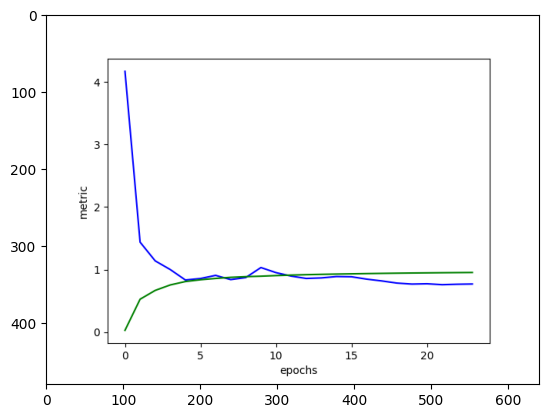

In [44]:
val_img = cv2.imread(f"{OUT_DIR}/valid_loss_24.png")
plt.imshow(val_img)